In [ ]:
# testing coadding of petal pattern for the FUV 
# some of this code is from the training I got several years on coadding which I haven't used since 

In [15]:
"""
ad-hoc demonstration of eclipse finding, coregistration, 
and semi-experimental coadd workflow in gPhoton 2. 

do not treat as a source of truth!!
"""
from pathlib import Path
import shutil
from astropy.io import fits


import astropy.wcs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fitsio

import sys
sys.path.append('/home/bekah/gPhoton2')

from gPhoton.coadd import (
    make_shared_wcs, 
    wcs_imsz, 
    bin_projected_weights,
    project_to_shared_wcs
)
from gPhoton.reference import eclipse_to_paths
from gPhoton.search.core import eclipses_near_object, filter_galex_eclipses

mpl.rcParams['image.cmap'] ='Greys_r'

DATA_ROOT = "/home/bekah/gPhoton2/test_data/e22644/images"

In [16]:
def centile_clip(image, centiles=(1, 99.5)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [17]:
images = tuple(Path(DATA_ROOT).iterdir())


In [18]:
images

(PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b01-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b03-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b06-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b04-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b00-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b05-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b02-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b07-image-r.fits'),
 PosixPath('/home/bekah/gPhoton2/test_data/e22644/images/e22644-nd-ffull-b08-image-r.fits'))

In [19]:
# 1-indexed because of the dummy primary HDU in rice-compressed files.
headers = [fitsio.FITS(image)[2].read_header() for image in images]
systems = [astropy.wcs.WCS(h) for h in headers]
# 'big' WCS that coregisters all images
shared_wcs = make_shared_wcs(systems)
coadd_imsz = wcs_imsz(shared_wcs)
# blank background layer for coadd
coadd_bg = np.zeros(wcs_imsz(shared_wcs), dtype=np.float64)

In [20]:
projections, layers = [], []
for image_ix in range(len(images)-1):
    # the 'x' and 'y' values of this dictionary are pixel indices in the shared WCS.
    # it doesn't strictly need to be saved for coadding; I'm showing extra steps.
    projection = project_to_shared_wcs(images[image_ix], shared_wcs, hdu_offset=1, nonzero=True, system=systems[image_ix])
    projections.append(projection)
    layers.append(
        bin_projected_weights(projection['x'], projection['y'], projection['weight'], coadd_imsz)
    )

In [21]:
# to actually coadd, you want to scale by exptime:
for image_ix in range(len(images)-1):
    coadd_bg += layers[image_ix] / projections[image_ix]['exptime']

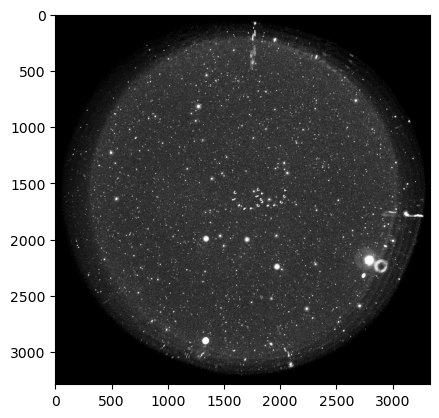

In [22]:
plt.imshow(centile_clip(coadd_bg))

In [23]:
eclipse = 'e22644'
hdu1 = fits.PrimaryHDU(coadd_bg)
hdulist = fits.HDUList([hdu1])
hdulist.writeto(f'e{eclipse}_coadd_nozfe.fits', overwrite=True)
print(f"done w {eclipse}")

done w e22644
